In [130]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)

In [131]:
stringency_dtype={
    'CountryName': "category",
    'CountryCode': "category",
    'RegionName': "category",
    "RegionCode": "category",
    "Jurisdiction": "category",
    "Date": "string",
    "C1_School closing": "float",
    "C1_Flag": "Int32",
    'C1_Notes': "string",
    'C2_Workplace closing': "float",
    'C2_Flag': "Int32",
    'C2_Notes': "string",
    'C3_Cancel public events': "float",
    'C3_Flag': "Int32",
    'C3_Notes': "string",
    'C4_Restrictions on gatherings': "float",
    'C4_Flag': "Int32",
    'C4_Notes': "string",
    'C5_Close public transport': "float",
    'C5_Flag': "Int32",
    'C5_Notes': "string",
    'C6_Stay at home requirements': "float",
    'C6_Flag': "Int32",
    'C6_Notes': "string",
    'C7_Restrictions on internal movement': "float",
    'C7_Flag': "Int32",
    'C7_Notes': "string",
    'C8_International travel controls': "float",
    'C8_Notes': "string",
    'E1_Income support': "float",
    'E1_Flag': "Int32",
    'E1_Notes': "string",
    'E2_Debt/contract relief': "float",
    'E2_Notes': "string",
    'E3_Fiscal measures': "float",
    'E3_Notes': "string",
    'E4_International support': "float",
    'E4_Notes': "string",
    'H1_Publicinformation campaigns': "float",
    'H1_Flag': "Int32",
    'H1_Notes': "string",
    'H2_Testing policy': "float",
    'H2_Notes': "string",
    'H3_Contact tracing': "float",
    'H3_Notes': "string",
    'H4_Emergency investment in healthcare': "float",
    'H4_Notes': "string",
    'H5_Investment in vaccines': "float",
    'H5_Notes': "string",
    'H6_Facial Coverings': "float",
    'H6_Flag': "Int32",
    'H6_Notes': "string",
    'H7_Vaccination policy': "float",
    'H7_Flag': "Int32",
    'H7_Notes': "string",
    'H8_Protection of elderly people': "float",
    'H8_Flag': "Int32",
    'H8_Notes': "string",
    'M1_Wildcard': "float",
    'M1_Notes': "string",
    'ConfirmedCases': "float",
    'ConfirmedDeaths': "float",
    'StringencyIndex': "float",
    'StringencyIndexForDisplay': "float",
    'StringencyLegacyIndex': "float",
    'StringencyLegacyIndexForDisplay': "float",
    'GovernmentResponseIndex': "float",
    'GovernmentResponseIndexForDisplay': "float",
    'ContainmentHealthIndex': "float",
    'ContainmentHealthIndexForDisplay': "float",
    'EconomicSupportIndex': "float",
    'EconomicSupportIndexForDisplay': "float",
}

stringency2020 = pd.read_csv(
    "../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes_2020.csv", dtype=stringency_dtype)
stringency2021 = pd.read_csv(
    "../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes_2021.csv", dtype=stringency_dtype)

# print(vaccines.columns.tolist())
vaccines = pd.read_csv("../nvme/oxcgrt-covid-policy-tracker/OxCGRT_vaccines_full.csv")
languages = pd.read_csv("./data/languages.csv", index_col="code")

def clean_stringency(df):
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("/", "_") for c in df.columns})
    df["c1_flag"] = df["c1_flag"].fillna(0).astype("bool")
    df["date"] = pd.to_datetime(df["date"])
    return df

def clean_vaccines(df):
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("/", "_") for c in df.columns})
    df["date"] = pd.to_datetime(df["date"].astype("string"))
    return df

stringency2020 = clean_stringency(stringency2020)
stringency2021 = clean_stringency(stringency2021)
stringency = pd.concat([stringency2020, stringency2021])
vaccines = clean_vaccines(vaccines)

In [132]:
stringency.head()

,countryname,countrycode,regionname,regioncode,jurisdiction,date,c1_school_closing,c1_flag,c1_notes,c2_workplace_closing,...,stringencyindex,stringencyindexfordisplay,stringencylegacyindex,stringencylegacyindexfordisplay,governmentresponseindex,governmentresponseindexfordisplay,containmenthealthindex,containmenthealthindexfordisplay,economicsupportindex,economicsupportindexfordisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,False,<NA>,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,False,<NA>,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,False,<NA>,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-04,0.0,False,<NA>,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-05,0.0,False,<NA>,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
# print(stringency.dtypes)
# print(stringency["stringencyindex"].unique().tolist())
vaccines.head()
pprint(vaccines.columns.tolist())

['countryname',
 'countrycode',
 'date',
 'v1_vaccine_prioritisation_(summary)',
 'v1_0-4_yrs_infants',
 'v1_5-15_yrs_young_people',
 'v1_airport_border_airline_staff',
 'v1_at_risk_16-19_yrs',
 'v1_at_risk_20-24_yrs',
 'v1_at_risk_25-29_yrs',
 'v1_at_risk_30-34_yrs',
 'v1_at_risk_35-39_yrs',
 'v1_at_risk_40-44_yrs',
 'v1_at_risk_45-49_yrs',
 'v1_at_risk_50-54_yrs',
 'v1_at_risk_55-59_yrs',
 'v1_at_risk_60-64_yrs',
 'v1_at_risk_65-69_yrs',
 'v1_at_risk_70-74_yrs',
 'v1_at_risk_75-79_yrs',
 'v1_at_risk_80+_yrs',
 'v1_clinically_vulnerable_chronic_illness_significant_underlying_health_condition_(excluding_elderly_and_disabled)',
 'v1_crowded_communal_living_conditions_(dormitories_for_migrant_workers,_temporary_accommodation)',
 'v1_disabled_people',
 'v1_educators',
 'v1_ethnic_minorities',
 'v1_factory_workers',
 'v1_frontline_retail_workers',
 'v1_frontline_essential_workers_(when_subcategories_not_specified)',
 'v1_general_16-19_yrs',
 'v1_general_20-24_yrs',
 'v1_general_25-29_yrs',

            stringencyindex
date                       
2020-01-01              0.0
2020-01-02              0.0
2020-01-03              0.0
2020-01-04              0.0
2020-01-05              0.0


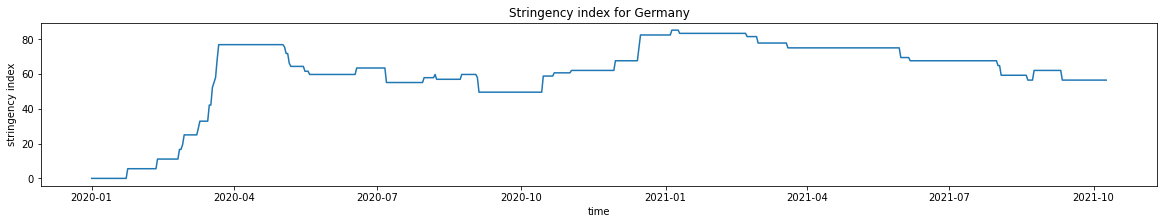

In [134]:
# plot the data for germany to get a feel
df = stringency
germany = df.loc[df["countryname"] == "Germany", ["date", "stringencyindex"]].set_index("date")
print(germany.head())
plt.plot(germany)
plt.title("Stringency index for Germany")
plt.xlabel("time")
plt.ylabel("stringency index")
plt.show()

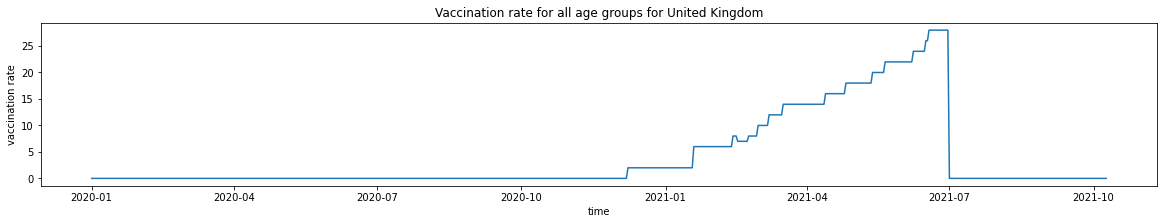

In [129]:
# plot the vaccination for germany to get a feel
df = vaccines
country = "Germany"
country = "United Kingdom"
age_groups = [
    'v3_general_16-19_yrs',
    'v3_general_20-24_yrs',
    'v3_general_25-29_yrs',
    'v3_general_30-34_yrs',
    'v3_general_35-39_yrs',
    'v3_general_40-44_yrs',
    'v3_general_45-49_yrs',
    'v3_general_50-54_yrs',
    'v3_general_55-59_yrs',
    'v3_general_60-64_yrs',
    'v3_general_65-69_yrs',
    'v3_general_70-74_yrs',
    'v3_general_75-79_yrs',
    'v3_general_80+_yrs',
]
germany = df.loc[df["countryname"] == country,:].copy()
germany["total"] = 0
for age in age_groups:
    germany["total"] += germany[age].fillna(0.0)
germany = germany[["date", "total"]].set_index("date")
plt.plot(germany)
plt.title("Vaccination rate for all age groups for %s" % country)
plt.xlabel("time")
plt.ylabel("vaccination rate")
plt.show()

In [ ]:
if False:
        df = df.rename(columns={
            "CountryName": "country_name",
            'CountryCode': "country_code",
            'RegionName': "region_name",
            "RegionCode": "region_code",
            "Jurisdiction": "jurisdiction",
            "Date": "date",
            "C1_School closing": "c1_school_closing",
            "C1_Flag": "c1_flag",
            "C1_Notes": "c1_notes",
            "C2_Workplace closing": "c2_workplace_closing",
            "StringencyIndex": "stringency_index",
            "StringencyIndexForDisplay": "stringency_index_for_display",
            "StringencyLegacyIndex": "stringency_legacy_index",
            "StringencyLegacyIndexForDisplay": "stringency_legacy_index_for_display",
            "GovernmentResponseIndex": "government_response_index",
            "GovernmentResponseIndexForDisplay": "government_response_index_for_display",
            "ContainmentHealthIndex": "containment_health_index",
            "ContainmentHealthIndexForDisplay": "containment_health_index_for_display",
            "EconomicSupportIndex": "economic_support_index",
            "EconomicSupportIndexForDisplay": "economic_support_index_for_display",
        })